<h1 style="text-align:center">调优模型和训练策略</h1>

## 作业介绍

模型调优和训练策略调优是当前深度学习领域最常见、最难和最耗费精力的工作，旨在降低训练难度，提高模型精度，减少模型大小，降低模型推理时延。本作业要求在给定LeNet5模型+CIFAR10数据集的基础上，对模型和训练策略进行调优，以验证精度、模型大小和推理时延为目标，优先级为精度>大小>时延。

要求模型在CIFAR10验证集上的精度不低于60%，最终成绩可参考`0.50*精度(%) - 0.35*大小(MB) - 0.15*时延(ms)`的方式评定。

## 作业目的

- 了解当前深度学习研发人员最常见的工作；
- 了解并熟悉如何使用MindSpore进行模型开发和调试；
- 了解模型调优的基本方向和常用策略，了解模型深度（层数）、模型宽度（核大小）、特殊结构（Bypass）等概念，及其对模型精度、大小和时延的影响；
- 了解训练策略调优的常用方法，了解Epoch数、Batch Size、优化器、学习率、正则化项等对模型训练和精度的影响。

## 预备知识

- 熟练使用Python，了解Shell及Linux操作系统基本知识。
- 具备一定的深度学习理论知识，如卷积神经网络、损失函数、优化器，训练策略、Checkpoint等。
- 了解华为云的基本使用方法，包括[OBS（对象存储）](https://www.huaweicloud.com/product/obs.html)、[ModelArts（AI开发平台）](https://www.huaweicloud.com/product/modelarts.html)、[Notebook（开发工具）](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0033.html)等功能。华为云官网：https://www.huaweicloud.com
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn/

## 开发环境

- MindSpore 0.1.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 华为云ModelArts：ModelArts是华为云提供的面向开发者的一站式AI开发平台，集成了昇腾AI处理器资源池，用户可以在该平台下体验MindSpore。ModelArts官网：https://www.huaweicloud.com/product/modelarts.html

## 开发准备

### 创建OBS桶

本实验需要使用华为云OBS存储脚本和数据集，可以参考[快速通过OBS控制台上传下载文件](https://support.huaweicloud.com/qs-obs/obs_qs_0001.html)了解使用OBS创建桶、上传文件、下载文件的使用方法。

> **提示：** 华为云新用户使用OBS时通常需要创建和配置“访问密钥”，可以在使用OBS时根据提示完成创建和配置。也可以参考[获取访问密钥并完成ModelArts全局配置](https://support.huaweicloud.com/prepare-modelarts/modelarts_08_0002.html)获取并配置访问密钥。

创建OBS桶的参考配置如下：

- 区域：华北-北京四
- 数据冗余存储策略：单AZ存储
- 桶名称：如ms-course
- 存储类别：标准存储
- 桶策略：公共读
- 归档数据直读：关闭
- 企业项目、标签等配置：免

### 数据集准备

CIFAR-10是一个图片分类数据集，包含60000张32x32的彩色物体图片，训练集50000张，测试集10000张，共10类，每类6000张。CIFAR-10数据集的官网：[THE MNIST DATABASE](http://www.cs.toronto.edu/~kriz/cifar.html)。

从CIFAR-10官网下载“CIFAR-10 binary version (suitable for C programs)”到本地并解压。

### 脚本准备

从[课程gitee仓库](https://gitee.com/mindspore/course)上下载对应的Jupyter Notebook（内容同本指导）。

### 上传文件

将脚本和数据集上传到OBS桶中，组织为如下形式：

```
project_1
├── xxx.ipynb
└── cifar10
    ├── batches.meta.txt
    ├── eval
    │   └── test_batch.bin
    └── train
        ├── data_batch_1.bin
        ├── data_batch_2.bin
        ├── data_batch_3.bin
        ├── data_batch_4.bin
        └── data_batch_5.bin
```

### 创建并打开Notebook

可以参考[创建并打开Notebook](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0034.html)来创建并打开上传的Notebook脚本。

创建Notebook的参考配置：

- 计费模式：按需计费
- 名称：project_1
- 工作环境：Python3
- 资源池：公共资源
- 类型：Ascend
- 规格：单卡1*Ascend 910
- 存储位置：对象存储服务（OBS）->选择上述新建的OBS桶中的project_1文件夹
- 自动停止等配置：默认

> **注意：**
> - 打开Notebook前，在Jupyter Notebook文件列表页面，勾选目录里的所有文件/文件夹（脚本和数据集），并点击列表上方的“Sync OBS”按钮，使OBS桶中的所有文件同时同步到Notebook工作环境中，这样Notebook中的代码才能访问数据集。参考[使用Sync OBS功能](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0038.html)。
> - 打开Notebook后，选择MindSpore环境作为Kernel。

> **提示：** 上述数据集和脚本的准备工作也可以在Notebook环境中完成，在Jupyter Notebook文件列表页面，点击右上角的"New"->"Terminal"，进入Notebook环境所在终端，进入`work`目录，可以使用常用的linux shell命令，如`wget, gzip, tar, mkdir, mv`等，完成数据集和脚本的下载和准备。

## 作业内容

作业基于上述打开的Notebook进行，进行作业前请确保完成了上述准备工作。

> **提示：** 请从上至下阅读提示并执行代码框进行体验。代码框执行过程中左侧呈现[\*]，代码框执行完毕后左侧呈现如[1]，[2]等。请等上一个代码框执行完毕后再执行下一个代码框。

导入MindSpore模块和辅助模块：

In [ ]:
import os
# os.environ['DEVICE_ID'] = '0'
import time

import matplotlib.pyplot as plt
import numpy as np

import mindspore as ms
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.transforms.vision.c_transforms as CV

from mindspore.dataset.transforms.vision import Inter
from mindspore import nn, Tensor
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net

import logging; logging.getLogger('matplotlib.font_manager').disabled = True

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

### 数据处理

对其中几张图片进行可视化，可以看到图片中的物体/动物，图片的大小为32x32。

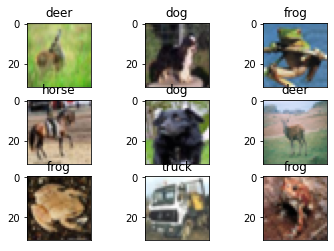

In [2]:
DATA_DIR_TRAIN = "cifar10rain" # 训练集信息
DATA_DIR_TEST = "cifar10/eval" # 测试集信息
LABELS = "cifar10/batches.meta.txt" # 标签信息

ds = ms.dataset.Cifar10Dataset(DATA_DIR_TRAIN)
ds = ds.create_dict_iterator()
with open(LABELS, "r") as f:
    labels = [x.strip() for x in f.readlines()]

for i in range(1, 10):
    data = ds.get_next() 
    plt.subplot(3, 3, i)
    plt.imshow(data['image'])
    plt.title('%s' % labels[data['label']])
    plt.xticks([])
plt.show()

在使用数据集训练网络前，首先需要对数据进行预处理，如下：

In [3]:
def create_dataset(training=True, num_epoch=1, batch_size=32, resize=(32, 32), rescale=1/255, shift=0, buffer_size=64):
    ds = ms.dataset.Cifar10Dataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    # define map operations
    if training:
        random_crop_op = CV.RandomCrop((32,32), (4,4,4,4))
        random_flip_op = CV.RandomHorizontalFlip()
        ds = ds.map(input_columns="image", operations=[random_crop_op, random_flip_op])
    
    resize_op = CV.Resize(resize)  # Bilinear as default
    rescale_op = CV.Rescale(rescale, shift)
    normalize_op = CV.Normalize((0.4465, 0.4822, 0.4914), (0.2010, 0.1994, 0.2023))
    changeswap_op = CV.HWC2CHW()
    
    # apply map operations on images
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, normalize_op, changeswap_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.repeat(num_epoch)
    
    return ds

### 定义模型

预置模型为LeNet5：

In [4]:
class MyNet(nn.Cell):
    def __init__(self):
        super(MyNet, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=1, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, pad_mode='valid')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(400, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, 10)
    
    def construct(self, input_x):
        output = self.conv1(input_x)
        output = self.relu(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.flatten(output)
        # print(output.shape()) # 仅Pynative模式时可用，Graph模式时请注释掉
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        
        return output

使用Pynative模式对网络进行调试，比如打印网络中某一层的输出shape：`print(output.shape())`。

In [5]:
context.set_context(mode=context.PYNATIVE_MODE)
x = Tensor(np.ones([1, 3, 32, 32]), ms.float32)
y = MyNet()(x)

> **注意：** 调试完毕后，需注释掉网络定义中`construct`里的打印语句：`print(output.shape())`，并将切换为Graph模式进行模型训练。

In [6]:
context.set_context(mode=context.GRAPH_MODE)

### 模型训练

一般情况下，模型训练时采用静态学习率，如0.01。随着训练步数的增加，模型逐渐趋于收敛，对权重参数的更新幅度应该逐渐降低，以减小模型训练后期的抖动。所以，模型训练时可以采用动态下降的学习率，常见的学习率下降策略有：

- polynomial decay/square decay;
- cosine decay;
- exponential decay;
- stage decay.

In [3]:
def build_lr(total_steps, decay_type='cosine', lr_base=0.1, lr_init=0.0, warmup_steps=0):
    """
    Generate learning rate array.

    Args:
        total_steps (int): Total steps to decay over.
        decay_type (str): cosine, square
        lr_base (float): Base learning rate. Default: 0.1.
        lr_init (float): Initial learning rate for warmup. Default: 0.0.
        warmup_steps (int): The number of warming up steps. Default: 5.

    Returns:
        np.array, learning rate array.
    """
    lr_base, lr_init = float(lr_base), float(lr_init)
    lr_per_step = []
    if warmup_steps != 0:
        inc_per_step = (lr_base - lr_init) / warmup_steps
    else:
        inc_per_step = 0.0
    for i in range(int(total_steps)):
        if i < warmup_steps:
            lr = lr_init + inc_per_step * i
        else:
            if decay_type == 'square':
                frac = 1.0 - float(i - warmup_steps) / (total_steps - warmup_steps)
                lr = lr_base * (frac * frac)
            elif decay_type == 'exponential':
                pass # 尝试实现
            elif decay_type == 'cosine':
                lr = 0.5 * lr_base * (1 + np.cos(np.pi * i / total_steps))
            else:
                raise
        lr_per_step.append(lr)
    
    lr_per_step = np.array(lr_per_step).astype(np.float32)
    return lr_per_step

观察不同学习率下降策略的曲线：

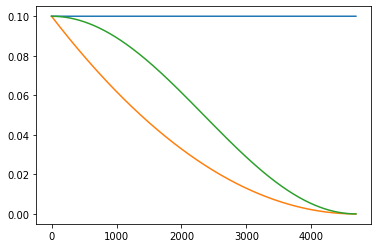

In [4]:
steps = 3*1562
plt.plot(range(steps), [0.1]*steps)
plt.plot(range(steps), build_lr(steps, decay_type='square', lr_base=0.1))
plt.plot(range(steps), build_lr(steps, decay_type='cosine', lr_base=0.1))
plt.show()

采用一定的训练策略对模型进行训练，并观察最终的验证精度。这里采用Momentum优化器 + cosine decay学习率下降策略。

- cosine0.1_epoch100:{'acc': 0.5056089743589743, 'loss': 1.3536554261659965}
- square0.1_epoch100:{'acc': 0.5385616987179487, 'loss': 1.2873077663855674}
- const0.01_epoch100:{'acc': 0.5464743589743589, 'loss': 1.3035117800419147}

- cosine0.1_epoch50:{'acc': 0.43900240384615385, 'loss': 1.5275637297294078}
- square0.1_epoch50:{'acc': 0.5453725961538461, 'loss': 1.2635320337154927}
- const0.01_epoch50:{'acc': 0.546073717948718, 'loss': 1.2912015158396501}

- cosine0.01_epoch50:{'acc': 0.6571514423076923, 'loss': 0.9970117075703083}

In [ ]:
os.system('rm -f *.ckpt *.ir *.meta') # 清理旧的运行文件
LOOP_SINK = context.get_context('enable_loop_sink')

def test_train(num_epoch=2, momentum=0.9, lr=0.01, decay_type='square', check_point_name="mynet"):
    ds_train = create_dataset(num_epoch=num_epoch)
    ds_eval = create_dataset(training=False)
    steps_per_epoch = ds_train.get_dataset_size()
    
    net = MyNet()
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')
    if decay_type:
        lr = build_lr(num_epoch*steps_per_epoch, decay_type=decay_type, lr_base=lr)
    opt = nn.Momentum(net.trainable_params(), lr, momentum, weight_decay=0.0)
    
    ckpt_cfg = CheckpointConfig(save_checkpoint_steps=steps_per_epoch, keep_checkpoint_max=5)
    ckpt_cb = ModelCheckpoint(prefix=check_point_name, config=ckpt_cfg)
    loss_cb = LossMonitor(per_print_times=1 if LOOP_SINK else steps_per_epoch)
    
    model = Model(net, loss, opt, metrics={'acc', 'loss'})
    model.train(num_epoch, ds_train, callbacks=[ckpt_cb, loss_cb], dataset_sink_mode=True)
    metrics = model.eval(ds_eval)
    print('Metrics:', metrics)

test_train(num_epoch=50, lr=0.01, decay_type='cosine')
print('\n'.join(sorted([x for x in os.listdir('.') if x.startswith('mynet')])))

### 模型大小

统计模型参数量，包括所有可训练的权重、偏置的参数。

In [39]:
params = MyNet().trainable_params()
print([(p.name, np.prod(p.data.shape())) for p in params])
num_params = sum([np.prod(p.data.shape()) for p in params])
print('Num params(M):', num_params/1e6)

[('conv1.weight', 450), ('conv2.weight', 2400), ('fc1.weight', 48000), ('fc1.bias', 120), ('fc2.weight', 10080), ('fc2.bias', 84), ('fc3.weight', 840), ('fc3.bias', 10)]
Num params(M): 0.061984


### 推理时延

模型第一次执行推理时需要编译计算图和算子，通常时延较长，通常需要先进行预热（warmup），然后再循环推理多次，取多次推理时延的平均值作为模型的推理时延。

In [37]:
x = Tensor(np.ones([1, 3, 32, 32]), ms.float32)
net = MyNet()
# 预热
for i in range(5):
    y = net(x)
# 多次推理取平均值
start = time.time()
for i in range(100):
    y = net(x)
end = time.time()
print('Latency(ms):', (end-start)/100 * 1000)

Latency(ms): 1.290428638458252


## 作业结论

预置训练策略，以及预置模型的精度、大小和时延如下：

| batch size | number of epochs | learning rate | decay type | optimizer | number of parameters(M) | latency(ms) | acc(%) |
| -- | -- | -- | -- | -- | -- | -- | -- |
| 32 | 50 | 0.01 | cosine | Momentum 0.9 | 0.061984 | 1.290 | 65.7 |

在预置模型和训练策略的基础上，请：

- 尝试调整模型深度（层数）、模型宽度（核大小）、模型结构（Conv, MaxPool, AvgPool, FC, Bypass）等，并评估其对模型精度、大小和时延的影响；
- 尝试调整Epoch数、Batch Size、优化器、学习率、正则化项等，并评估其对模型训练和精度的影响。

调优模型和训练策略的结果（请填写）：

| batch size | number of epochs | learning rate | decay type | optimizer | number of parameters(M) | latency(ms) | acc(%) |
| -- | -- | -- | -- | -- | -- | -- | -- |
| x | x | x | x | x | x | x | x |

### 模型调优总结

请填写

### 训练策略调优总结

请填写
